In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import patsy
import math
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
# Import county gini index data
gini_index_df = pd.read_csv('county_gini_index.csv', encoding='latin-1', header = 1)
# Drop the two ID columns which will not be used
gini_index_df = gini_index_df.drop(columns = ['Id', 'Id2'])

gini_index_df.head(10)

,Geography,Estimate; Gini Index,Margin of Error; Gini Index
0,"Baldwin County, Alabama",0.4363,0.0196
1,"Calhoun County, Alabama",0.4892,0.0460
2,"Cullman County, Alabama",0.4121,0.0193
3,"DeKalb County, Alabama",0.4975,0.0488
4,"Elmore County, Alabama",0.4307,0.0325
5,"Etowah County, Alabama",0.4657,0.0288
6,"Houston County, Alabama",0.4805,0.0173
7,"Jefferson County, Alabama",0.5048,0.0125
8,"Lauderdale County, Alabama",0.4486,0.0362
9,"Lee County, Alabama",0.4714,0.0259


In [3]:
# Rename the column with county and state to county_name
gini_index_df.rename(columns = {'Geography':'county_name'}, inplace = True)
# Dictionary used to convert the state name to its abbreviation
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'District of Columbia',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

newcol = []
# Loop through the gini index dataframe and convert the state name to its abbreviation
for countystate in gini_index_df.iterrows():
    # Get the county and state name
    strcounty = str(countystate[1][0])
    
    # Separate the county name from the state name
    county = strcounty.split(',')[0].strip()
    longstate = strcounty.split(',')[1].strip()
    
    # Search through the dictionary for the state name and change it to its abbreviation
    for state, stateabbrev in us_state_abbrev.items():
        if longstate == state:
            newcountystate = county + ', ' + stateabbrev
            newcol.append(newcountystate)

# Replace the old county and state name column with the new county and abbreviated state column
gini_index_df['county_name'] = newcol
gini_index_df.shape

(826, 3)

In [4]:
# Load the county crime data
df_crime = pd.read_csv('crime_data_w_population_and_crime_rate.csv')
df_crime.shape

(3136, 24)

In [5]:
# Merge gini index dataframe with crime dataframe using the county_name columns
df = pd.merge(gini_index_df, df_crime, on=['county_name'])
df.shape

(824, 26)

In [6]:
# Get the general statistics of the dataframe
df.describe()

,Estimate; Gini Index,Margin of Error; Gini Index,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,AG_ARRST,...,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,population,FIPS_ST,FIPS_CTY
count,824.000000,824.000000,824.000000,824.000000,824.0,824.0,824.000000,8.240000e+02,8.240000e+02,824.000000,...,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,8.240000e+02,824.000000,824.000000
mean,0.450118,0.024637,325.380362,1108.953883,1.0,4.0,1559.822816,3.194490e+05,3.173267e+05,13.093447,...,85.000000,408.972087,798.451456,2175.633495,6444.571602,804.411408,55.753641,3.232581e+05,29.902913,93.041262
std,0.034900,0.011561,214.876185,768.559781,0.0,0.0,939.366675,5.683582e+05,5.666971e+05,12.917149,...,138.117626,1245.700796,1689.661968,3995.638590,11359.707346,2347.962986,124.310741,5.728475e+05,15.529779,108.975125
min,0.332100,0.003800,33.704873,1.000000,1.0,4.0,2.000000,1.438600e+04,1.438600e+04,1.000000,...,1.000000,1.000000,1.000000,77.000000,212.000000,5.000000,0.000000,5.947100e+04,1.000000,1.000000
25%,0.425950,0.016800,170.501354,433.750000,1.0,4.0,656.500000,9.254725e+04,9.057950e+04,5.750000,...,23.000000,31.000000,134.000000,538.750000,1649.500000,96.000000,10.000000,9.351475e+04,17.000000,27.000000
50%,0.449100,0.023200,272.567962,1017.000000,1.0,4.0,1789.500000,1.502695e+05,1.493775e+05,9.000000,...,42.000000,76.500000,295.500000,979.000000,3043.500000,196.000000,22.000000,1.531140e+05,33.000000,67.000000
75%,0.472700,0.029925,430.992259,1691.250000,1.0,4.0,2306.250000,3.172732e+05,3.144070e+05,16.000000,...,91.000000,247.500000,694.000000,2112.750000,6439.750000,501.000000,54.000000,3.184648e+05,42.000000,117.000000
max,0.594300,0.079800,1791.995377,2862.000000,1.0,4.0,3167.000000,9.980757e+06,9.980757e+06,150.000000,...,1976.000000,18923.000000,23057.000000,49107.000000,142604.000000,40555.000000,2210.000000,1.001707e+07,56.000000,810.000000


(array([  2.,  20.,  90., 180., 243., 180.,  84.,  17.,   7.,   1.]),
 array([0.3321 , 0.35832, 0.38454, 0.41076, 0.43698, 0.4632 , 0.48942,
        0.51564, 0.54186, 0.56808, 0.5943 ]),
 <a list of 10 Patch objects>)

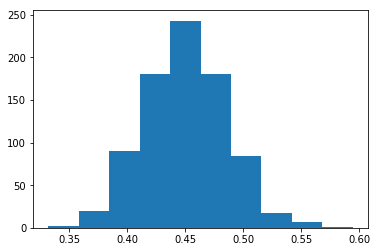

In [7]:
# Separate out the gini index value into the variable gini
gini = df['Estimate; Gini Index']
# Plot a histogram of the gini index values to get an idea of what the data looks like
plt.hist(gini)

0.006917925353100614
The distribution of crime index for income inequality existing is not approximately normal.


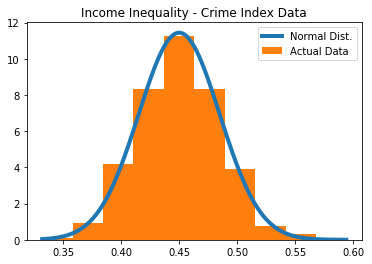

In [8]:
# Test to see if the gini index values are normal
st_gini, p_gini = normaltest(gini)
print(p_gini)
if p_gini > 0.01:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
xs = np.arange(min(gini), max(gini), 0.001)
fit = stats.norm.pdf(xs, np.mean(gini), np.std(gini))
plt.plot(xs, fit, label = 'Normal Dist.', lw = 4)
plt.hist(gini, density = True, label = 'Actual Data');
plt.title('Income Inequality - Crime Index Data')
plt.legend();

(array([  2.,   6.,  34., 113., 201., 252., 151.,  50.,  13.,   2.]),
 array([-1.10231915, -1.04412434, -0.98592953, -0.92773472, -0.86953991,
        -0.81134509, -0.75315028, -0.69495547, -0.63676066, -0.57856585,
        -0.52037104]),
 <a list of 10 Patch objects>)

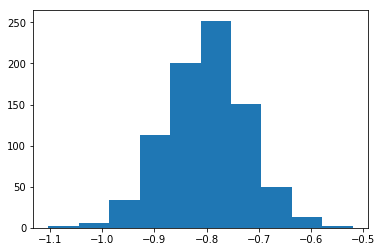

In [9]:
# Since the gini index data is not quite normal, use a log transformation to normalize it
transform_gini = np.log(gini)
# Go through 
#for i in range(len(gini)):
#    # log transformation
#    y = math.log(gini[i])
#    shifted_gini.append(y)

# Plot a histogram of the transformed gini data
plt.hist(transform_gini)

0.14120794756663999
The distribution of crime index for income inequality existing is approximately normal.


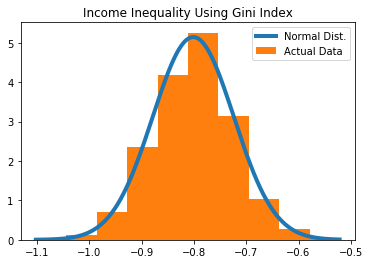

In [10]:
st_gini_transform, p_gini_transform = normaltest(transform_gini)
print(p_gini_transform)
if p_gini_transform > 0.01:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
xs_transform = np.arange(min(transform_gini), max(transform_gini), 0.001)
fit_transform = stats.norm.pdf(xs_transform, np.mean(transform_gini), np.std(transform_gini))
plt.plot(xs_transform, fit_transform, label = 'Normal Dist.', lw = 4)
plt.hist(transform_gini, density = True, label = 'Actual Data');
plt.title('Income Inequality Using Gini Index')
plt.legend();

df['Transformed Gini Index'] = transform_gini

In [11]:
df

,county_name,Estimate; Gini Index,Margin of Error; Gini Index,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,...,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,population,FIPS_ST,FIPS_CTY,Transformed Gini Index
0,"Baldwin County, AL",0.4363,0.0196,228.086325,1298,1,4,2,187467,187467,...,76,332,967,3829,192,31,195540,1,3,-0.829425
1,"Calhoun County, AL",0.4892,0.0460,580.797697,189,1,4,8,122213,118270,...,131,504,1710,3482,147,34,116736,1,15,-0.714984
2,"Cullman County, AL",0.4121,0.0193,237.591417,1232,1,4,22,80832,80859,...,13,161,483,1483,99,6,80811,1,43,-0.886489
3,"DeKalb County, AL",0.4975,0.0488,381.620267,564,1,4,25,71683,71662,...,9,242,558,1085,131,10,71013,1,49,-0.698160
4,"Elmore County, AL",0.4307,0.0325,284.294579,958,1,4,26,80528,80484,...,44,159,665,1367,85,14,80902,1,51,-0.842343
5,"Etowah County, AL",0.4657,0.0288,513.802427,284,1,4,28,103809,97544,...,126,361,1241,2674,294,42,103931,1,55,-0.764214
6,"Houston County, AL",0.4805,0.0173,401.281012,502,1,4,35,103678,102780,...,108,259,1095,2380,184,18,103668,1,69,-0.732928
7,"Jefferson County, AL",0.5048,0.0125,798.357491,59,1,4,37,686887,659396,...,1597,3315,9910,19810,1809,185,659479,1,73,-0.683593
8,"Lauderdale County, AL",0.4486,0.0362,262.939535,1070,1,4,39,93154,93154,...,55,157,612,1600,100,6,92797,1,77,-0.801624
9,"Lee County, AL",0.4714,0.0259,246.466975,1166,1,4,41,139698,144044,...,77,261,954,2942,128,9,150933,1,81,-0.752048


In [12]:
# Find the median gini index and use this to divide the data into two subgroups, with and without income inequality
gini_median = df['Transformed Gini Index'].median()

ineq_exists = [0]*len(df)
for i in range(0,len(df)):
    if df['Transformed Gini Index'][i] >= gini_median:
        ineq_exists[i] = 1
    else:
        ineq_exists[i] = 0
df['inequality exists'] = ineq_exists  
df.head()

,county_name,Estimate; Gini Index,Margin of Error; Gini Index,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,...,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,population,FIPS_ST,FIPS_CTY,Transformed Gini Index,inequality exists
0,"Baldwin County, AL",0.4363,0.0196,228.086325,1298,1,4,2,187467,187467,...,332,967,3829,192,31,195540,1,3,-0.829425,0
1,"Calhoun County, AL",0.4892,0.0460,580.797697,189,1,4,8,122213,118270,...,504,1710,3482,147,34,116736,1,15,-0.714984,1
2,"Cullman County, AL",0.4121,0.0193,237.591417,1232,1,4,22,80832,80859,...,161,483,1483,99,6,80811,1,43,-0.886489,0
3,"DeKalb County, AL",0.4975,0.0488,381.620267,564,1,4,25,71683,71662,...,242,558,1085,131,10,71013,1,49,-0.698160,1
4,"Elmore County, AL",0.4307,0.0325,284.294579,958,1,4,26,80528,80484,...,159,665,1367,85,14,80902,1,51,-0.842343,0


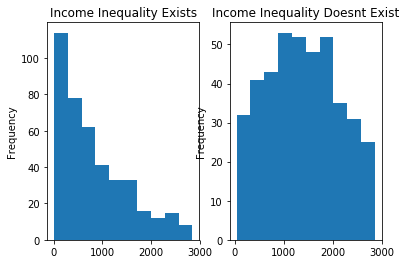

In [13]:
# Side-by-side histogram plots of crime index in areas with and without income inequality
fig, axes = plt.subplots(1, 2)

df[df["inequality exists"] == 1]["index"].plot.hist(ax = axes[0], title = 'Income Inequality Exists')
df[df["inequality exists"] == 0]["index"].plot.hist(ax = axes[1], title = 'Income Inequality Doesn''t Exist')
crime_ineq = df[df["inequality exists"] == 1]["index"]
crime_no_ineq = df[df["inequality exists"] == 0]["index"]

In [14]:
#Use t test to check if there is a significant difference in crime between the areas with and without income inequality
t_val, p_val = ttest_ind(crime_ineq, crime_no_ineq)

if p_val < 0.01:
    print('There is a significant difference.')
else:
    print('There is NOT a significant difference.')

There is a significant difference.


In [15]:
crime_ineq = df[df["inequality exists"] == 1]["index"].values
crime_no_ineq = df[df["inequality exists"] == 0]["index"].values

st_ineq, p_ineq = normaltest(crime_ineq)
st_no_ineq, p_no_ineq = normaltest(crime_no_ineq)

In [16]:
is_n_ineq = bool(p_ineq > 0.01)
if is_n_ineq == True:
    print('The distribution of crime index for income inequality existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality existing is not approximately normal.')
    
is_n_no_ineq = bool(p_no_ineq > 0.01)
if is_n_no_ineq == True:
    print('The distribution of crime index for income inequality not existing is approximately normal.')
else:
    print('The distribution of crime index for income inequality not existing is not approximately normal.')
    
print(len(crime_ineq), len(crime_no_ineq))

The distribution of crime index for income inequality existing is not approximately normal.
The distribution of crime index for income inequality not existing is not approximately normal.
412 412


(array([ 6., 17., 25., 32., 40., 56., 64., 67., 56., 49.]),
 array([ 6.4807407 , 11.18243298, 15.88412526, 20.58581754, 25.28750982,
        29.9892021 , 34.69089438, 39.39258666, 44.09427894, 48.79597122,
        53.4976635 ]),
 <a list of 10 Patch objects>)

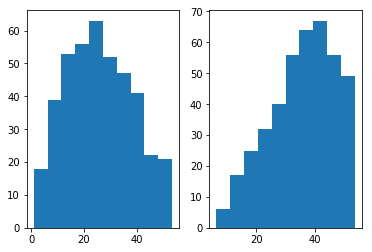

In [17]:
out = []
out1 = []
for i in range(len(crime_ineq)):
    # log transformation
    out.append(crime_ineq[i]**(1/2))
    out1.append(crime_no_ineq[i]**(1/2))
#    shifted_gini.append(y)

figz, ax = plt.subplots(1, 2)
ax[0].hist(out)
ax[1].hist(out1)